<a href="https://colab.research.google.com/github/garylau1/model_training/blob/main/GNN_model_to_detect_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Fake News Detection:

In this project, our goal  is to train Graph Neural
Network (GNN) models to detect fake news on Twitter. We will do a graph-level classification
task aimed at predicting whether a given graph corresponds to fake news.


The "gossipcop" dataset contains tree-structured graphs representing the spread of fake and real news on Twitter. Each graph shows the source news at the top (the root) and the users who retweeted it at the bottom (the leaves). The nodes represent users and news, and the edges show who retweeted from whom. Four different types of information about each node (user or news) are included.

More details can be found in the GNN-FakeNews repository:

https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.UPFD.html#torch_geometric.datasets.UPFD




In [ ]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import UPFD
from torch_geometric.utils import to_networkx



In [ ]:
# Load the UPFD dataset for the "profile" feature
dataset = UPFD(root='content/data/UPFD', feature="profile",name="gossipcop")



Extracting content/data/UPFD/gossipcop/raw/data.zip
Processing...
Done!


## Exploration of dataset:



Node Features:

Feature "Profile": A 10-dimensional vector representing the profile attributes of the Twitter user (e.g., number of followers, number of tweets).

Labels:

Each graph has a label indicating whether the news article is fake or real.
0: Real news.
1: Fake news.

Root node:

Represent the source news

leaf node:

Represent the individual Twitter user who retweeted a specific news item

In [ ]:
# Print some information about the dataset
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print (dataset)

# Access the first graph in the dataset
# Note that in this case, we have 188 graphs in the dataset. Each graph represents one chemical compound
data = dataset[0]
print(f'\nFirst graph in the dataset: {data}')
print('===============================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of features(one graph): {data.num_features}')


Dataset: UPFD(1092, name=gossipcop, feature=profile):
Number of graphs: 1092
Number of features: 10
Number of classes: 2
UPFD(1092, name=gossipcop, feature=profile)

First graph in the dataset: Data(x=[76, 10], edge_index=[2, 75], y=[1])
Number of nodes: 76
Number of edges: 75
Average node degree: 0.99
Contains isolated nodes: False
Contains self-loops: False
Is undirected: False
Number of features(one graph): 10


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


We can check whether the number of fake news and real news are in approxmately in balance:

In [ ]:
Num_real = sum(dataset.y==1).item()
Fake_real = sum(dataset.y==0).item()
print (f"the number of non-fake news is : {round(Num_real,3)}")
print (f"the number of non-fake news is : {round(Fake_real,3)}")

the number of non-fake news is : 535
the number of non-fake news is : 557


We can explore the number of the isloated nodes of the whole dataset:

It turned out there is none

In [ ]:
count=0
for i in range(len(dataset)):
  if dataset[i].contains_isolated_nodes():
    count=count+1
print (f"the number of isolated nodes or edges are {count}")

the number of isolated nodes or edges are 0


We can also plot one of the datapoint of the graph:

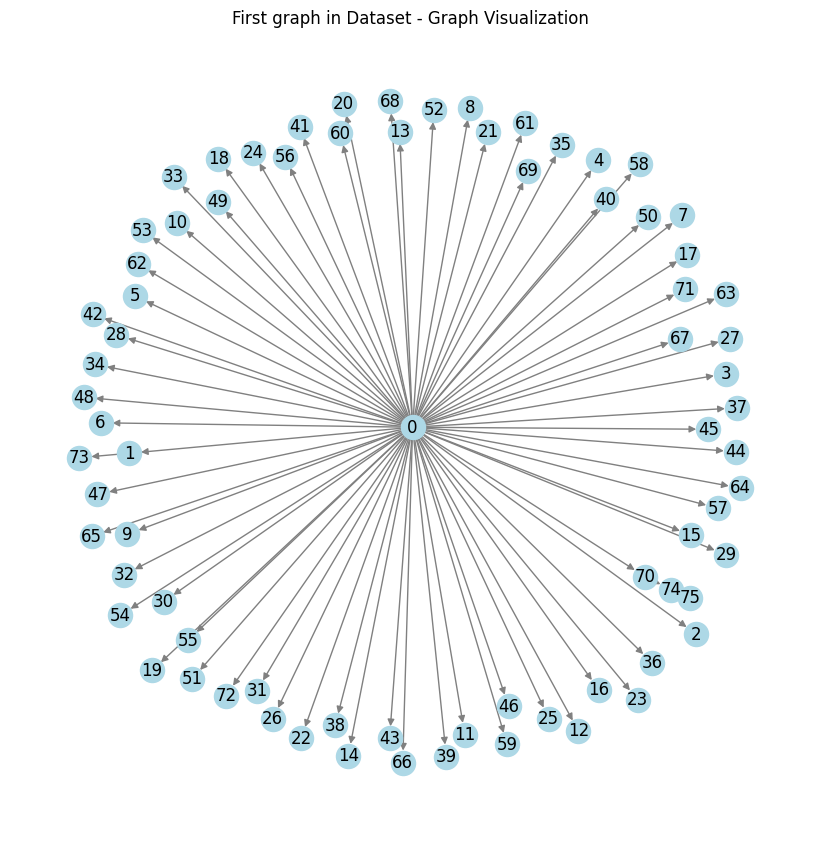

In [ ]:
# Convert the graph to a NetworkX graph for visualization
G = to_networkx(data, to_undirected=False)

# Draw the graph
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title('First graph in Dataset - Graph Visualization')
plt.show()

We can further print out the one graph to have a look.

We have 10 features of each node:

In [ ]:
dataset.x[0]   # ten features of this node

tensor([0.0000, 0.0000, 0.0060, 0.0039, 0.0289, 0.0020, 0.0043, 0.6794, 0.1175,
        0.1534])

## Data preprocessing:

In [ ]:
from torch_geometric.loader import DataLoader

def inductive_split(dataset, split_ratio, batch_size, val_ratio=0.1):
    # TODO: Implement a function to split the dataset into training dataset and test dataset
    # using inductive setting.
    # dataset: The PyTorch Geometric graph dataset.
    # split_ratio(float): Ratio of nodes to be used for training.
    # batch_size(int): batch_size for the dataloader

    ############# Your code here ############
    # Shuffle the dataset
    dataset = dataset.shuffle()

    # Split the dataset into train and test sets
    # Calculate sizes for training, validation, and test sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    # Split the dataset into training, validation, and test sets
    train_dataset = dataset[:train_size]
    val_dataset = dataset[train_size:train_size + val_size]
    test_dataset = dataset[train_size + val_size:]

    # Wrap the datset using Dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    #########################################

    return train_loader, val_loader,test_loader

train_loader, val_loader,test_loader = inductive_split(dataset, split_ratio=0.8, batch_size=32)


We split out dataset into train,test and validation set:

In [ ]:
print("Training dataset length:", len(train_loader.dataset))
print("Testing dataset length:", len(test_loader.dataset))
print("Validation dataset length:", len(val_loader.dataset))

Training dataset length: 873
Testing dataset length: 110
Validation dataset length: 109


We used the train ,test and accuracy function to train/evaluate our model:

In [ ]:
# Run the training and testing for GCN Model
# Define the optimizers for the three models
from torch_geometric.nn import GATConv, BatchNorm
from torch_geometric.nn import global_add_pool, global_mean_pool
import torch.nn as nn
import torch.nn.functional as F


# Training loop

def train(model, optimizer):

    """Trains a graph neural network model using a provided optimizer.

    This function iterates through a training data loader, performs a forward pass
    through the model, calculates the binary cross-entropy loss with logits,
    backpropagates the gradients, updates the model parameters using the optimizer,
    and accumulates the total loss. Finally, it calculates and returns the average loss
    across the entire training dataset.

    Args:
        model: The graph neural network model to be trained.
        optimizer: The optimizer used to update the model parameters.

    Returns:
        The average loss over the entire training dataset.
    """

    model.train()

    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)

        # Use binary cross-entropy loss
        loss = F.binary_cross_entropy_with_logits(out.squeeze(), data.y.to(torch.float32))

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def accuracy(model, loader):

    """Calculates the accuracy of a graph neural network model on a given data loader.

    This function iterates through a data loader, performs a forward pass through the
    model, applies a sigmoid activation to the output, classifies predictions based on
    a 0.5 threshold, compares them to the ground truth labels, and accumulates the
    number of correct predictions. Finally, it calculates and returns the accuracy
    over the entire dataset.

    Args:
        model: The graph neural network model to be evaluated.
        loader: The data loader containing the test or validation dataset.

    Returns:
        The accuracy of the model on the given dataset.
    """
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)

            # Apply sigmoid to get probabilities and classify based on 0.5 threshold
            pred = torch.sigmoid(out.squeeze()) >= 0.5

            correct += int(pred.eq(data.y).sum().item())
    return correct / len(loader.dataset)



def test(model, optimizer):

    """
    Evaluates the trained graph neural network model on the test set.

    Args:
        model (torch.nn.Module): The trained graph neural network model.
        optimizer (torch.optim.Optimizer): The optimizer used during training (not used in evaluation).

    Returns:
        float: The average loss (binary cross-entropy) over the entire test dataset.
    """

    model.eval()

    total_loss = 0

    for data in test_loader:

        out = model(data.x, data.edge_index, data.batch)

        # Use binary cross-entropy loss
        loss = F.binary_cross_entropy_with_logits(out.squeeze(), data.y.to(torch.float32))



        total_loss += loss.item() * data.num_graphs
    return total_loss / len(test_loader.dataset)

## Our Model training:

GraphGAT:

In this part we will make a GAT morel.
GAT aggregates information from neighboring nodes using a multi-headed attention mechanism. This means it assigns different weights to neighboring nodes based on their importance. The final layer of the network updates node features using this weighted aggregation.


We choose two GTA convolutional layers because with a relatively small dataset of around 1000 data points, a single layer might be insufficient to extract meaningful features from the input data.
If there are too many layers, we may encounter the over-smoothing problem.
GAT over-smoothes with many layers because each layer aggregates information from neighboring nodes. As more layers are added, information from distant nodes becomes more dominant, leading to a loss of fine-grained structure.






Hyerparameter tuning:


We train a GAT model with only head but with 2 GAT convoluation layers.
In this task we add batch_norm layer ,drop out layer and add hidden neurons with Hyperparameter tuning.


Hyperparameter tuning is essential in Graph Attention Networks (GATs) to optimize the model's performance and stability. GATs, like most machine learning models, involve various hyperparameters that directly affect their ability to learn from the data.In this task we use Optuna to perform Hyperparameter tuning.

Optuna is a popular hyperparameter optimization library that can be used to efficiently tune the hyperparameters of PyTorch models.




In [ ]:
!pip install optuna  #install if there is none

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, BatchNorm
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import UPFD
from sklearn.metrics import accuracy_score
import optuna

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, BatchNorm

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, BatchNorm


class GAT(torch.nn.Module):
    """Graph Attention Network (GAT) for graph classification.

    This class implements a GAT model with two attention layers, batch normalization,
    residual connections, and a final linear layer for classification.

    Args:
        input_channels (int): Number of input features per node.
        hidden_channels (int): Number of hidden features per node.
        head (int): Number of attention heads.
        dropout (float): Dropout probability.

    Attributes:
        conv1 (GATConv): First GAT convolutional layer.
        conv2 (GATConv): Second GAT convolutional layer.
        batch_norm1 (BatchNorm): Batch normalization layer after the first GAT layer.
        batch_norm2 (BatchNorm): Batch normalization layer after the second GAT layer.
        dropout (nn.Dropout): Dropout layer.
        residual_linear1 (nn.Linear): Linear layer for residual connection after the first GAT layer.
        residual_linear2 (nn.Linear): Linear layer for residual connection after the second GAT layer.
        linear (nn.Linear): linear layer for classification.

    """

    def __init__(self, input_channels, hidden_channels, head, dropout):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_channels, hidden_channels, heads=head)
        self.conv2 = GATConv(hidden_channels * head, hidden_channels)

        self.batch_norm1 = BatchNorm(hidden_channels * head)
        self.batch_norm2 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

        # Align input dimensions to match GAT layer output for residual connection
        self.residual_linear1 = torch.nn.Linear(input_channels, hidden_channels * head)
        self.residual_linear2 = torch.nn.Linear(hidden_channels * head, hidden_channels)

        self.linear = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # First GAT layer with residual connection
        x_residual = self.residual_linear1(x)  # Align input dimension
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Add residual connection after dimension alignment
        x = x + x_residual

        # Second GAT layer with another residual connection
        x_residual = self.residual_linear2(x)  # Align dimension for second layer
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Add second residual connection
        x = x + x_residual

        # Global mean pooling and final linear layer
        x = global_mean_pool(x, batch)
        x = self.linear(x)

        return torch.sigmoid(x).squeeze()  # Apply sigmoid activation and squeeze to get a scalar probability




# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to optimize
    hidden_channels = trial.suggest_int("hidden_channels", 8, 72, step=8)
    head = trial.suggest_int("head", 2, 9)
    dropout = trial.suggest_float("dropout", 0.2, 0.8)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    # Initialize the model and optimizer
    model = GAT(input_channels=dataset.num_features, hidden_channels=hidden_channels,
                head=head, dropout=dropout).to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    model.train()
    for epoch in range(15):  # Use a small number of epochs for quick tuning
        for data in train_loader:
            data = data.to('cuda' if torch.cuda.is_available() else 'cpu')
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = F.binary_cross_entropy(out, data.y.float())
            loss.backward()
            optimizer.step()

    # Evaluation on the test set
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for data in val_loader:
            data = data.to('cuda' if torch.cuda.is_available() else 'cpu')
            out = model(data.x, data.edge_index, data.batch)
            preds.extend((out > 0.5).cpu().numpy())
            labels.extend(data.y.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(labels, preds)
    return accuracy

# Run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2024-10-15 11:07:09,319] A new study created in memory with name: no-name-32751cac-f404-4385-997f-0a08a9d30fd8
<ipython-input-13-d6aeca3e1ace>:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2024-10-15 11:07:41,707] Trial 0 finished with value: 0.944954128440367 and parameters: {'hidden_channels': 40, 'head': 6, 'dropout': 0.4848476794425338, 'lr': 0.0023738560390592495}. Best is trial 0 with value: 0.944954128440367.
<ipython-input-13-d6aeca3e1ace>:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2024-10-15 11:08:04,816] Trial 1 finished with value: 0.91743119266

KeyboardInterrupt: 

I stop here because I found the accuracy is high enough.I would not perform more trial. This is our final best parameters:

In [ ]:
study.best_params  #print out the best hyperparmeters we tune

{'hidden_channels': 56,
 'head': 8,
 'dropout': 0.5055604518371759,
 'lr': 0.004219812579396007}

Our original GAT model:

In [ ]:
class GAT(torch.nn.Module):
    """Graph Attention Network (GAT) for graph classification.

      This class implements a GAT model with two attention layers, batch normalization,
      residual connections, and a final linear layer for classification.

      Args:
          input_channels (int): Number of input features per node.
          hidden_channels (int): Number of hidden features per node.
          head (int): Number of attention heads.
          dropout (float): Dropout probability.

      Attributes:
          conv1 (GATConv): First GAT convolutional layer.
          conv2 (GATConv): Second GAT convolutional layer.
          batch_norm1 (BatchNorm): Batch normalization layer after the first GAT layer.
          batch_norm2 (BatchNorm): Batch normalization layer after the second GAT layer.
          dropout (nn.Dropout): Dropout layer.
          residual_linear1 (nn.Linear): Linear layer for residual connection after the first GAT layer.
          residual_linear2 (nn.Linear): Linear layer for residual connection after the second GAT layer.
          linear (nn.Linear): Final linear layer for classification.
      """
    def __init__(self, input_channels, hidden_channels, head, dropout):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_channels, hidden_channels, heads=head)
        self.conv2 = GATConv(hidden_channels * head, hidden_channels)

        self.batch_norm1 = BatchNorm(hidden_channels * head)
        self.batch_norm2 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

        # Align input dimensions to match GAT layer output for a variant of residual connection
        self.residual_linear1 = torch.nn.Linear(input_channels, hidden_channels * head)
        self.residual_linear2 = torch.nn.Linear(hidden_channels * head, hidden_channels)

        self.linear = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # First GAT layer with residual connection
        x_residual = self.residual_linear1(x)  # Align input dimension
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Add residual connection after dimension alignment
        x = x + x_residual

        # Second GAT layer with another residual connection
        x_residual = self.residual_linear2(x)  # Align dimension for second layer
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Add second residual connection
        x = x + x_residual

        # Global mean pooling and final linear layer
        x = global_mean_pool(x, batch)
        x = self.linear(x)

        return x

In [ ]:
GATmodel = GAT(dataset.num_node_features,study.best_params["hidden_channels"],study.best_params["head"],study.best_params["dropout"])

#Creates an instance of the GAT model using the optimal hyperparameters found through hyperparameter tuning with Optuna.
#The dataset.num_node_features is used as the input dimension for the model.


GAToptimizer = torch.optim.Adam(GATmodel.parameters(), lr=study.best_params["lr"])
#Initializes an Adam optimizer with the optimal learning rate found through hyperparameter tuning.

results_1 = {
    'loss': [],
    'test_acc': [],"train loss":[],"train_acc":[]}
#Creates a dictionary results_1 to store the training loss and test accuracy for each epoch.

for epoch in range(30):   #Iterates over the specified number of epochs
    train_loss = train(GATmodel, GAToptimizer)
    train_acc = accuracy(GATmodel, train_loader)
    test_acc = accuracy(GATmodel, test_loader)
    loss=test(GATmodel, GAToptimizer)
    results_1['loss'].append(loss)
    results_1['test_acc'].append(test_acc)
    results_1['train loss'].append(train_loss)
    results_1['train_acc'].append(train_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Loss: 0.7571, Train Acc: 0.5567, Test Acc: 0.5364
Epoch: 001, Loss: 0.6480, Train Acc: 0.6529, Test Acc: 0.6545
Epoch: 002, Loss: 0.3254, Train Acc: 0.9072, Test Acc: 0.9000
Epoch: 003, Loss: 0.2565, Train Acc: 0.8946, Test Acc: 0.9000
Epoch: 004, Loss: 0.2091, Train Acc: 0.8694, Test Acc: 0.9000
Epoch: 005, Loss: 0.2243, Train Acc: 0.9061, Test Acc: 0.9091
Epoch: 006, Loss: 0.4969, Train Acc: 0.7136, Test Acc: 0.7000
Epoch: 007, Loss: 0.2597, Train Acc: 0.9003, Test Acc: 0.8636
Epoch: 008, Loss: 0.4775, Train Acc: 0.7148, Test Acc: 0.7091
Epoch: 009, Loss: 0.2521, Train Acc: 0.9061, Test Acc: 0.8909
Epoch: 010, Loss: 0.1717, Train Acc: 0.9198, Test Acc: 0.9364
Epoch: 011, Loss: 0.2949, Train Acc: 0.8751, Test Acc: 0.8545
Epoch: 012, Loss: 0.1638, Train Acc: 0.9038, Test Acc: 0.9455
Epoch: 013, Loss: 0.1986, Train Acc: 0.9198, Test Acc: 0.9182
Epoch: 014, Loss: 0.1149, Train Acc: 0.9393, Test Acc: 0.9545
Epoch: 015, Loss: 0.1115, Train Acc: 0.9370, Test Acc: 0.9636
Epoch: 0

We will plot the train loss,test loss ,test accuracy and train accuracy in the graphs:

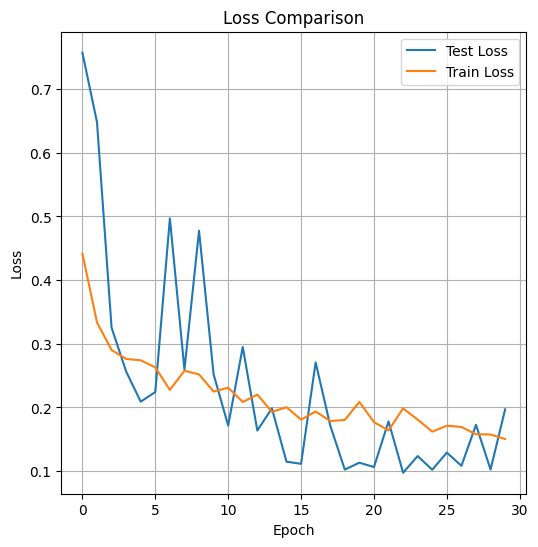

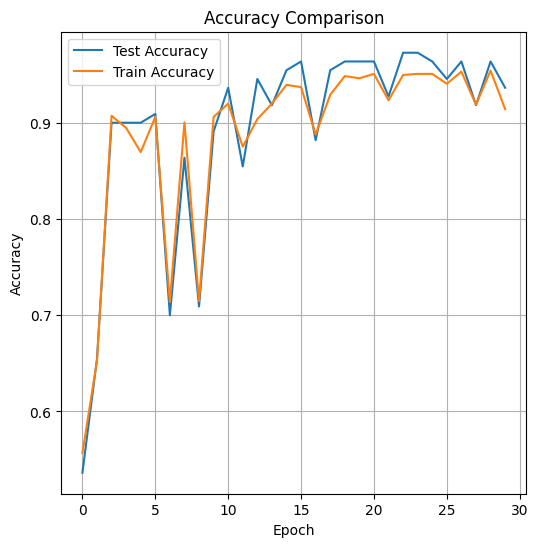

In [ ]:
import matplotlib.pyplot as plt


# Plot 1: Comparing loss and training loss
plt.figure(figsize=(6, 6))
plt.plot(results_1['loss'], label='Test Loss')
plt.plot(results_1['train loss'], label='Train Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Comparing accuracy and training accuracy
plt.figure(figsize=(6, 6))
plt.plot(results_1['test_acc'], label='Test Accuracy')
plt.plot(results_1['train_acc'], label='Train Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

It looks nice. But we can do more and have ablation studies of our model.


From model 2 to  model 6, We will systematically remove certain design elements from your model architecture to assess their impact on model performance.

Model 2:

We remove one single layer:

In [ ]:
class GAT(torch.nn.Module):

    """Graph Attention Network (GAT) for graph classification.

        This class implements a GAT model with one attention layer, batch normalization,
        residual connections, and a final linear layer for classification.

        Args:
            input_channels (int): Number of input features per node.
            hidden_channels (int): Number of hidden features per node.
            head (int): Number of attention heads.
            dropout (float): Dropout probability.

        Attributes:
            conv1 (GATConv): First GAT convolutional layer.

            batch_norm1 (BatchNorm): Batch normalization layer after the first GAT layer.

            dropout (nn.Dropout): Dropout layer.
            residual_linear1 (nn.Linear): Linear layer for residual connection after the first GAT layer.

            linear (nn.Linear): Final linear layer for classification.
        """

    def __init__(self, input_channels, hidden_channels, head, dropout):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_channels, hidden_channels, heads=head)
        #self.conv2 = GATConv(hidden_channels * head, hidden_channels)

        self.batch_norm1 = BatchNorm(hidden_channels * head)
        #self.batch_norm2 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

        # Align input dimensions to match GAT layer output for a variant of residual connection
        self.residual_linear1 = torch.nn.Linear(input_channels, hidden_channels * head)
        #self.residual_linear2 = torch.nn.Linear(hidden_channels * head, hidden_channels)

        self.linear = torch.nn.Linear(hidden_channels* head, 1)

    def forward(self, x, edge_index, batch):
        # First GAT layer with residual connection
        x_residual = self.residual_linear1(x)  # Align input dimension
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Add residual connection after dimension alignment
        x = x + x_residual

        # Second GAT layer with another residual connection
        #x_residual = self.residual_linear2(x)  # Align dimension for second layer
        #x = self.conv2(x, edge_index)
        #x = self.batch_norm2(x)
        #x = F.relu(x)
        #x = self.dropout(x)

        # Add second residual connection
        #x = x + x_residual

        # Global mean pooling and final linear layer
        x = global_mean_pool(x, batch)
        x = self.linear(x)

        return x

In [ ]:
GATmodel = GAT(dataset.num_node_features,study.best_params["hidden_channels"],study.best_params["head"],study.best_params["dropout"])

#Creates an instance of the GAT model using the optimal hyperparameters found through hyperparameter tuning with Optuna.
#The dataset.num_node_features is used as the input dimension for the model.


GAToptimizer = torch.optim.Adam(GATmodel.parameters(), lr=study.best_params["lr"])
#Initializes an Adam optimizer with the optimal learning rate found through hyperparameter tuning.

results_2 = {
    'loss': [],
    'test_acc': []
}
#Creates a dictionary results_2 to store the training loss and test accuracy for each epoch.

for epoch in range(30):   #Iterates over the specified number of epochs
    train_loss = train(GATmodel, GAToptimizer)
    train_acc = accuracy(GATmodel, train_loader)
    test_acc = accuracy(GATmodel, test_loader)
    loss=test(GATmodel, GAToptimizer)
    results_2['loss'].append(loss)
    results_2['test_acc'].append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Loss: 0.7006, Train Acc: 0.5510, Test Acc: 0.5364
Epoch: 001, Loss: 0.4725, Train Acc: 0.7480, Test Acc: 0.7273
Epoch: 002, Loss: 0.2980, Train Acc: 0.8958, Test Acc: 0.9000
Epoch: 003, Loss: 0.4202, Train Acc: 0.7881, Test Acc: 0.8000
Epoch: 004, Loss: 0.2347, Train Acc: 0.9038, Test Acc: 0.9091
Epoch: 005, Loss: 0.2519, Train Acc: 0.8992, Test Acc: 0.9182
Epoch: 006, Loss: 0.1835, Train Acc: 0.9233, Test Acc: 0.9273
Epoch: 007, Loss: 0.2752, Train Acc: 0.9003, Test Acc: 0.8727
Epoch: 008, Loss: 0.2196, Train Acc: 0.9141, Test Acc: 0.9182
Epoch: 009, Loss: 0.2008, Train Acc: 0.9038, Test Acc: 0.9000
Epoch: 010, Loss: 0.1557, Train Acc: 0.9290, Test Acc: 0.9273
Epoch: 011, Loss: 0.1614, Train Acc: 0.9324, Test Acc: 0.9364
Epoch: 012, Loss: 0.1439, Train Acc: 0.9324, Test Acc: 0.9545
Epoch: 013, Loss: 0.1566, Train Acc: 0.9267, Test Acc: 0.9364
Epoch: 014, Loss: 0.1344, Train Acc: 0.9416, Test Acc: 0.9455
Epoch: 015, Loss: 0.1149, Train Acc: 0.9313, Test Acc: 0.9545
Epoch: 0

Model 3:


We further remove residue connection layers:

In [ ]:
class GAT(torch.nn.Module):

    """
        Graph Attention Network (GAT) for graph classification.

        This class implements a GAT model with one attention layer, batch normalization,
        and a final linear layer for classification.

        Args:
            input_channels (int): Number of input features per node.
            hidden_channels (int): Number of hidden features per node.
            head (int): Number of attention heads.
            dropout (float): Dropout probability.

        Attributes:
            conv1 (GATConv): First GAT convolutional layer.

            batch_norm1 (BatchNorm): Batch normalization layer after the first GAT layer.

            dropout (nn.Dropout): Dropout layer.


            linear (nn.Linear): Final linear layer for classification.
        """

    def __init__(self, input_channels, hidden_channels, head, dropout):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_channels, hidden_channels, heads=head)
        #self.conv2 = GATConv(hidden_channels * head, hidden_channels)

        self.batch_norm1 = BatchNorm(hidden_channels * head)
        #self.batch_norm2 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

        # Align input dimensions to match GAT layer output for a variant of residual connection
        #self.residual_linear1 = torch.nn.Linear(input_channels, hidden_channels * head)
        #self.residual_linear2 = torch.nn.Linear(hidden_channels * head, hidden_channels)

        self.linear = torch.nn.Linear(hidden_channels* head, 1)

    def forward(self, x, edge_index, batch):
        # First GAT layer with residual connection
        #x_residual = self.residual_linear1(x)  # Align input dimension
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Add residual connection after dimension alignment
        #x = x + x_residual

        # Second GAT layer with another residual connection
        #x_residual = self.residual_linear2(x)  # Align dimension for second layer
        #x = self.conv2(x, edge_index)
        #x = self.batch_norm2(x)
        #x = F.relu(x)
        #x = self.dropout(x)

        # Add second residual connection
        #x = x + x_residual

        # Global mean pooling and final linear layer
        x = global_mean_pool(x, batch)
        x = self.linear(x)

        return x

In [ ]:
GATmodel = GAT(dataset.num_node_features,study.best_params["hidden_channels"],study.best_params["head"],study.best_params["dropout"])

#Creates an instance of the GAT model using the optimal hyperparameters found through hyperparameter tuning with Optuna.
#The dataset.num_node_features is used as the input dimension for the model.


GAToptimizer = torch.optim.Adam(GATmodel.parameters(), lr=study.best_params["lr"])
#Initializes an Adam optimizer with the optimal learning rate found through hyperparameter tuning.

results_3 = {
    'loss': [],
    'test_acc': []
}
#Creates a dictionary results_3 to store the training loss and test accuracy for each epoch.

for epoch in range(30):   #Iterates over the specified number of epochs
    train_loss = train(GATmodel, GAToptimizer)
    train_acc = accuracy(GATmodel, train_loader)
    test_acc = accuracy(GATmodel, test_loader)
    loss=test(GATmodel, GAToptimizer)
    results_3['loss'].append(loss)
    results_3['test_acc'].append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Loss: 0.6168, Train Acc: 0.6850, Test Acc: 0.7000
Epoch: 001, Loss: 0.4519, Train Acc: 0.7824, Test Acc: 0.8091
Epoch: 002, Loss: 0.3111, Train Acc: 0.8969, Test Acc: 0.9000
Epoch: 003, Loss: 0.2539, Train Acc: 0.9015, Test Acc: 0.9182
Epoch: 004, Loss: 0.3324, Train Acc: 0.8774, Test Acc: 0.8545
Epoch: 005, Loss: 0.2815, Train Acc: 0.9038, Test Acc: 0.9000
Epoch: 006, Loss: 0.2548, Train Acc: 0.9061, Test Acc: 0.9091
Epoch: 007, Loss: 0.2945, Train Acc: 0.9003, Test Acc: 0.8818
Epoch: 008, Loss: 0.2957, Train Acc: 0.8958, Test Acc: 0.8818
Epoch: 009, Loss: 0.2052, Train Acc: 0.9187, Test Acc: 0.9091
Epoch: 010, Loss: 0.2144, Train Acc: 0.9107, Test Acc: 0.9182
Epoch: 011, Loss: 0.1557, Train Acc: 0.9187, Test Acc: 0.9182
Epoch: 012, Loss: 0.2121, Train Acc: 0.9118, Test Acc: 0.9091
Epoch: 013, Loss: 0.2293, Train Acc: 0.9107, Test Acc: 0.9091
Epoch: 014, Loss: 0.1644, Train Acc: 0.9324, Test Acc: 0.9545
Epoch: 015, Loss: 0.1822, Train Acc: 0.9210, Test Acc: 0.9273
Epoch: 0

Model 4:

We remove the batch_norm layer:

In [ ]:
class GAT(torch.nn.Module):

    """
    Graph Attention Network (GAT) for graph classification.

    This class implements a GAT model with one attention layer,
    and a final linear layer for classification.

    Args:
        input_channels (int): Number of input features per node.
        hidden_channels (int): Number of hidden features per node.
        head (int): Number of attention heads.
        dropout (float): Dropout probability.

    Attributes:
        conv1 (GATConv): First GAT convolutional layer.


        dropout (nn.Dropout): Dropout layer.


        linear (nn.Linear): Final linear layer for classification.
    """

    def __init__(self, input_channels, hidden_channels, head, dropout):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_channels, hidden_channels, heads=head)
        #self.conv2 = GATConv(hidden_channels * head, hidden_channels)

        #self.batch_norm1 = BatchNorm(hidden_channels * head)
        #self.batch_norm2 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=dropout)

        # Align input dimensions to match GAT layer output for a variant of residual connection
        #self.residual_linear1 = torch.nn.Linear(input_channels, hidden_channels * head)
        #self.residual_linear2 = torch.nn.Linear(hidden_channels * head, hidden_channels)

        self.linear = torch.nn.Linear(hidden_channels* head, 1)

    def forward(self, x, edge_index, batch):
        # First GAT layer with residual connection
        #x_residual = self.residual_linear1(x)  # Align input dimension
        x = self.conv1(x, edge_index)
        #x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Add residual connection after dimension alignment
        #x = x + x_residual

        # Second GAT layer with another residual connection
        #x_residual = self.residual_linear2(x)  # Align dimension for second layer
        #x = self.conv2(x, edge_index)
        #x = self.batch_norm2(x)
        #x = F.relu(x)
        #x = self.dropout(x)

        # Add second residual connection
        #x = x + x_residual

        # Global mean pooling and final linear layer
        x = global_mean_pool(x, batch)
        x = self.linear(x)

        return x


GATmodel = GAT(dataset.num_node_features,study.best_params["hidden_channels"],study.best_params["head"],study.best_params["dropout"])

#Creates an instance of the GAT model using the optimal hyperparameters found through hyperparameter tuning with Optuna.
#The dataset.num_node_features is used as the input dimension for the model.


GAToptimizer = torch.optim.Adam(GATmodel.parameters(), lr=study.best_params["lr"])
#Initializes an Adam optimizer with the optimal learning rate found through hyperparameter tuning.

results_4 = {
    'loss': [],
    'test_acc': []
}
#Creates a dictionary results_4 to store the training loss and test accuracy for each epoch.

for epoch in range(30):   #Iterates over the specified number of epochs
    train_loss = train(GATmodel, GAToptimizer)
    train_acc = accuracy(GATmodel, train_loader)
    test_acc = accuracy(GATmodel, test_loader)
    loss=test(GATmodel, GAToptimizer)
    results_4['loss'].append(loss)
    results_4['test_acc'].append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Loss: 0.6337, Train Acc: 0.6277, Test Acc: 0.6364
Epoch: 001, Loss: 0.4776, Train Acc: 0.8041, Test Acc: 0.8000
Epoch: 002, Loss: 0.4454, Train Acc: 0.8683, Test Acc: 0.8727
Epoch: 003, Loss: 0.4076, Train Acc: 0.8454, Test Acc: 0.8182
Epoch: 004, Loss: 0.4059, Train Acc: 0.8477, Test Acc: 0.8364
Epoch: 005, Loss: 0.3930, Train Acc: 0.8717, Test Acc: 0.8636
Epoch: 006, Loss: 0.3813, Train Acc: 0.8797, Test Acc: 0.8818
Epoch: 007, Loss: 0.3780, Train Acc: 0.8832, Test Acc: 0.8727
Epoch: 008, Loss: 0.3634, Train Acc: 0.8751, Test Acc: 0.8636
Epoch: 009, Loss: 0.4135, Train Acc: 0.8442, Test Acc: 0.8091
Epoch: 010, Loss: 0.3582, Train Acc: 0.8889, Test Acc: 0.8727
Epoch: 011, Loss: 0.3349, Train Acc: 0.8877, Test Acc: 0.8909
Epoch: 012, Loss: 0.3298, Train Acc: 0.8774, Test Acc: 0.8818
Epoch: 013, Loss: 0.3165, Train Acc: 0.8877, Test Acc: 0.9000
Epoch: 014, Loss: 0.3185, Train Acc: 0.8786, Test Acc: 0.9000
Epoch: 015, Loss: 0.3088, Train Acc: 0.8820, Test Acc: 0.9000
Epoch: 0

Model 5:

We remove the dropout layer, resulting in a simpler model with a single GATconvolution layer (along with a ReLU layer, global_mean_pool, and linear layer)."

In [ ]:
class GAT(torch.nn.Module):


    """
    Graph Attention Network (GAT) for graph classification.

    This class implements a GAT model with one attention layer,
    and a final linear layer for classification.

    Args:
        #we keep the dropout but we dont use it
        dropout (float): Dropout probability.
        input_channels (int): Number of input features per node.
        hidden_channels (int): Number of hidden features per node.
        head (int): Number of attention heads.


    Attributes:
        conv1 (GATConv): First GAT convolutional layer.





        linear (nn.Linear): Final linear layer for classification.
    """

    def __init__(self, input_channels, hidden_channels, head, dropout):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_channels, hidden_channels, heads=head)


        self.linear = torch.nn.Linear(hidden_channels*head, 1)

    def forward(self, x, edge_index, batch):
        # First GAT layer with residual connection
        #x_residual = self.residual_linear1(x)  # Align input dimension
        x = self.conv1(x, edge_index)
        #x = self.batch_norm1(x)
        x = F.relu(x)
        #x = self.dropout(x)

        # Add residual connection after dimension alignment
        #x = x + x_residual

        # Second GAT layer with another residual connection
        #x_residual = self.residual_linear2(x)  # Align dimension for second layer
        #x = self.conv2(x, edge_index)
        #x = self.batch_norm2(x)
        #x = F.relu(x)
        #x = self.dropout(x)

        # Add second residual connection
        #x = x + x_residual

        # Global mean pooling and final linear layer
        x = global_mean_pool(x, batch)
        x = self.linear(x)

        return x


GATmodel = GAT(dataset.num_node_features,study.best_params["hidden_channels"],study.best_params["head"],study.best_params["dropout"])

#Creates an instance of the GAT model using the optimal hyperparameters found through hyperparameter tuning with Optuna.
#The dataset.num_node_features is used as the input dimension for the model.


GAToptimizer = torch.optim.Adam(GATmodel.parameters(), lr=study.best_params["lr"])
#Initializes an Adam optimizer with the optimal learning rate found through hyperparameter tuning.

results_5 = {
    'loss': [],
    'test_acc': []
}
#Creates a dictionary results_5 to store the training loss and test accuracy for each epoch.

for epoch in range(30):   #Iterates over the specified number of epochs
    train_loss = train(GATmodel, GAToptimizer)
    train_acc = accuracy(GATmodel, train_loader)
    test_acc = accuracy(GATmodel, test_loader)
    loss=test(GATmodel, GAToptimizer)
    results_5['loss'].append(loss)
    results_5['test_acc'].append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Loss: 0.6029, Train Acc: 0.7320, Test Acc: 0.7273
Epoch: 001, Loss: 0.4489, Train Acc: 0.8225, Test Acc: 0.8000
Epoch: 002, Loss: 0.4244, Train Acc: 0.8339, Test Acc: 0.8091
Epoch: 003, Loss: 0.4107, Train Acc: 0.8511, Test Acc: 0.8182
Epoch: 004, Loss: 0.4107, Train Acc: 0.8454, Test Acc: 0.8182
Epoch: 005, Loss: 0.4157, Train Acc: 0.8740, Test Acc: 0.8636
Epoch: 006, Loss: 0.3899, Train Acc: 0.8740, Test Acc: 0.8636
Epoch: 007, Loss: 0.3870, Train Acc: 0.8855, Test Acc: 0.8818
Epoch: 008, Loss: 0.3641, Train Acc: 0.8855, Test Acc: 0.8727
Epoch: 009, Loss: 0.3574, Train Acc: 0.8946, Test Acc: 0.9000
Epoch: 010, Loss: 0.3572, Train Acc: 0.8889, Test Acc: 0.9000
Epoch: 011, Loss: 0.3413, Train Acc: 0.8923, Test Acc: 0.8818
Epoch: 012, Loss: 0.3374, Train Acc: 0.8648, Test Acc: 0.8545
Epoch: 013, Loss: 0.3315, Train Acc: 0.8958, Test Acc: 0.9000
Epoch: 014, Loss: 0.3149, Train Acc: 0.8935, Test Acc: 0.9000
Epoch: 015, Loss: 0.3042, Train Acc: 0.8900, Test Acc: 0.8909
Epoch: 0

Model 6:

We Finally remove muti-head attention with single one attention layer:

In [ ]:
class GAT(torch.nn.Module):


    """
    Graph Attention Network (GAT) for graph classification.

    This class implements a (one head) GAT model with one attention layer,
    and a final linear layer for classification.

    Args:

        input_channels (int): Number of input features per node.
        hidden_channels (int): Number of hidden features per node.
        # head (int): Number of attention heads. we keep it but we dont use it


    Attributes:
        conv1 (GATConv): First GAT convolutional layer.





        linear (nn.Linear): Final linear layer for classification.
    """

    def __init__(self, input_channels, hidden_channels, head, dropout):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_channels, hidden_channels, heads=1)


        self.linear = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # First GAT layer with residual connection
        #x_residual = self.residual_linear1(x)  # Align input dimension
        x = self.conv1(x, edge_index)
        #x = self.batch_norm1(x)
        x = F.relu(x)
        #x = self.dropout(x)

        # Add residual connection after dimension alignment
        #x = x + x_residual

        # Second GAT layer with another residual connection
        #x_residual = self.residual_linear2(x)  # Align dimension for second layer
        #x = self.conv2(x, edge_index)
        #x = self.batch_norm2(x)
        #x = F.relu(x)
        #x = self.dropout(x)

        # Add second residual connection
        #x = x + x_residual

        # Global mean pooling and final linear layer
        x = global_mean_pool(x, batch)
        x = self.linear(x)

        return x


GATmodel = GAT(dataset.num_node_features,study.best_params["hidden_channels"],study.best_params["head"],study.best_params["dropout"])

#Creates an instance of the GAT model using the optimal hyperparameters found through hyperparameter tuning with Optuna.
#The dataset.num_node_features is used as the input dimension for the model.


GAToptimizer = torch.optim.Adam(GATmodel.parameters(), lr=study.best_params["lr"])
#Initializes an Adam optimizer with the optimal learning rate found through hyperparameter tuning.

results_6 = {
    'loss': [],
    'test_acc': []
}
#Creates a dictionary results_5 to store the training loss and test accuracy for each epoch.

for epoch in range(30):   #Iterates over the specified number of epochs
    train_loss = train(GATmodel, GAToptimizer)
    train_acc = accuracy(GATmodel, train_loader)
    test_acc = accuracy(GATmodel, test_loader)
    loss=test(GATmodel, GAToptimizer)
    results_6['loss'].append(loss)
    results_6['test_acc'].append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Loss: 0.6573, Train Acc: 0.6770, Test Acc: 0.6636
Epoch: 001, Loss: 0.5974, Train Acc: 0.7331, Test Acc: 0.7455
Epoch: 002, Loss: 0.5286, Train Acc: 0.7881, Test Acc: 0.7818
Epoch: 003, Loss: 0.4709, Train Acc: 0.8156, Test Acc: 0.8091
Epoch: 004, Loss: 0.4468, Train Acc: 0.8499, Test Acc: 0.8636
Epoch: 005, Loss: 0.4167, Train Acc: 0.8351, Test Acc: 0.8182
Epoch: 006, Loss: 0.4067, Train Acc: 0.8454, Test Acc: 0.8273
Epoch: 007, Loss: 0.3994, Train Acc: 0.8465, Test Acc: 0.8273
Epoch: 008, Loss: 0.4065, Train Acc: 0.8488, Test Acc: 0.8364
Epoch: 009, Loss: 0.4496, Train Acc: 0.8706, Test Acc: 0.8545
Epoch: 010, Loss: 0.4076, Train Acc: 0.8671, Test Acc: 0.8636
Epoch: 011, Loss: 0.4228, Train Acc: 0.8396, Test Acc: 0.8273
Epoch: 012, Loss: 0.4079, Train Acc: 0.8580, Test Acc: 0.8455
Epoch: 013, Loss: 0.3988, Train Acc: 0.8797, Test Acc: 0.8818
Epoch: 014, Loss: 0.3978, Train Acc: 0.8797, Test Acc: 0.8818
Epoch: 015, Loss: 0.3918, Train Acc: 0.8706, Test Acc: 0.8818
Epoch: 0

##Visualization and Evaluation of Metrics:


Loss and Test Accuracy


We can print out all test accuracys and loss values in each 6 models:

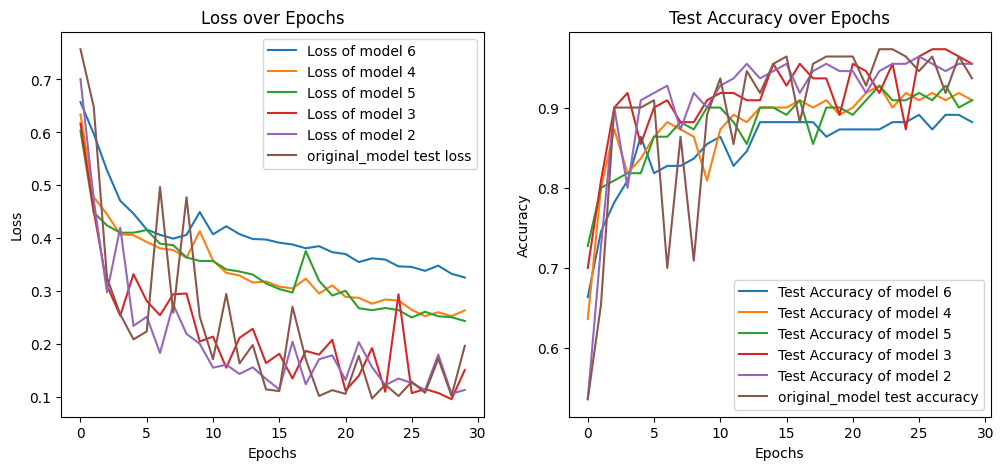

In [ ]:
import matplotlib.pyplot as plt

# Plotting loss and test accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(results_6['loss'], label='Loss of model 6')
plt.plot(results_4['loss'], label='Loss of model 4')
plt.plot(results_5['loss'], label='Loss of model 5')
plt.plot(results_3['loss'], label='Loss of model 3')
plt.plot(results_2['loss'], label='Loss of model 2')
plt.plot(results_1['loss'], label='original_model test loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(results_6['test_acc'], label='Test Accuracy of model 6')
plt.plot(results_4['test_acc'], label='Test Accuracy of model 4')
plt.plot(results_5['test_acc'], label='Test Accuracy of model 5')
plt.plot(results_3['test_acc'], label='Test Accuracy of model 3')
plt.plot(results_2['test_acc'], label='Test Accuracy of model 2')
plt.plot(results_1['test_acc'], label='original_model test accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

We can also plot the bar charts to compare our lost and accuracy:

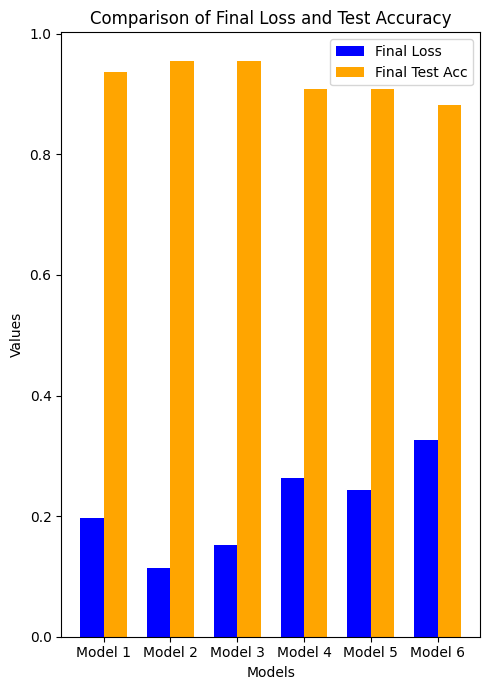

In [ ]:
import numpy as np



# Extracting final values
final_loss_1 = results_1['loss'][-1]
final_loss_2 = results_2['loss'][-1]
final_loss_3 = results_3['loss'][-1]
final_loss_4 = results_4['loss'][-1]

final_loss_5 = results_5['loss'][-1]
final_loss_6 = results_6['loss'][-1]

final_test_acc_1 = results_1['test_acc'][-1]
final_test_acc_2 = results_2['test_acc'][-1]
final_test_acc_3 = results_3['test_acc'][-1]
final_test_acc_4 = results_4['test_acc'][-1]
final_test_acc_5 = results_5['test_acc'][-1]
final_test_acc_6 = results_6['test_acc'][-1]
# Data for plotting
labels = ['Model 1', 'Model 2',"Model 3","Model 4","Model 5","Model 6"]
losses = [final_loss_1, final_loss_2, final_loss_3, final_loss_4, final_loss_5,final_loss_6]
test_accs = [final_test_acc_1, final_test_acc_2,final_test_acc_3,final_test_acc_4,final_test_acc_5,final_test_acc_6]

# Set up bar width and positions
bar_width = 0.35
x = np.arange(len(labels))  # The label locations

# Create subplots
fig, ax = plt.subplots(figsize=(5, 7))

# Bar plot for loss

bars1 = ax.bar(x - bar_width/2, losses, bar_width, label='Final Loss', color='blue')

# Bar plot for test accuracy
bars2 = ax.bar(x + bar_width/2, test_accs, bar_width, label='Final Test Acc', color='orange')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Values')
ax.set_title('Comparison of Final Loss and Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

We can print out the final result:

In [ ]:
results_list = [results_1, results_2, results_3, results_4, results_5,results_6]
#store in a list to display
for i, result in enumerate(results_list, start=1):
    final_loss = result['loss'][-1]
    final_test_acc = result['test_acc'][-1]
    print(f"  Model {i}:")
    print(f"  Final Loss: {final_loss:.4f}")
    print(f"  Final Test Accuracy: {final_test_acc:.4f}")

  Model 1:
  Final Loss: 0.1971
  Final Test Accuracy: 0.9364
  Model 2:
  Final Loss: 0.1137
  Final Test Accuracy: 0.9545
  Model 3:
  Final Loss: 0.1515
  Final Test Accuracy: 0.9545
  Model 4:
  Final Loss: 0.2639
  Final Test Accuracy: 0.9091
  Model 5:
  Final Loss: 0.2439
  Final Test Accuracy: 0.9091
  Model 6:
  Final Loss: 0.3261
  Final Test Accuracy: 0.8818
